# Basic Logistic Regression Model

Testing the model with selected features.

__Imports__

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Stylization for personal preference, not necessary for functionality.
# import jupyterthemes as jt
# context = jt.jtplot.set_context()
# jt.jtplot.set_style(context, 'monokai' )
# jt.stylefx.set_nb_theme('monokai')


## Read in the data and instantiate logistic regression model

In [3]:
df = pd.read_csv("../data/device_failure_data_scientist.csv")
df.head()

,date,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure
0,15001,S1F01085,215630672,56,0,52,6,407438,0,0,7,0
1,15001,S1F0166B,61370680,0,3,0,6,403174,0,0,0,0
2,15001,S1F01E6Y,173295968,0,0,0,12,237394,0,0,0,0
3,15001,S1F01JE0,79694024,0,0,0,6,410186,0,0,0,0
4,15001,S1F01R2B,135970480,0,0,0,15,313173,0,0,3,0


In [5]:
features = df.drop(columns=['date', 'device', 'failure'])
labels = df['failure']

In [6]:
X = features
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [7]:
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [8]:
lr = LogisticRegression()

lr.fit(X_train_ss, y_train)

C:\Users\flake\Anaconda3\envs\ga_dsi\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

## LogReg metrics

Accuracy right in line with baseline model

In [9]:
lr.score(X_test_ss, y_test)

0.9991003727027374

In [10]:
np.exp(lr.coef_)

array([[1.07603891, 1.12960874, 0.91789541, 1.07313492, 1.11898813,
        1.10443473, 1.03516407, 1.03516407, 1.00665627]])

**Coefficients (odds of failing):**

- `attribute1` = $1.08$
- `attribute2` = $1.13$
- `attribute3` = $0.92$
- `attribute4` = $1.07$
- `attribute5` = $1.12$
- `attribute6` = $1.10$
- `attribute7` = $1.04$
- `attribute8` = $1.04$
- `attribute9` = $1.01$

In [11]:
# Generate predictions.
preds = lr.predict(X_test_ss)

In [12]:
# Generate confusion matrix.
confusion_matrix(y_test, # True values.
                 preds)  # Predicted values

array([[31096,     1],
       [   27,     0]], dtype=int64)

In [13]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel() 

In [14]:
# Specificity and Sensitivity

spec = tn / (tn + fp) 
sens = tp / (tp + fn) 

print(f'Specificity: {spec}')
print(f'Sensitivity: {sens}')

Specificity: 0.9999678425571599
Sensitivity: 0.0


### ROC AUC 

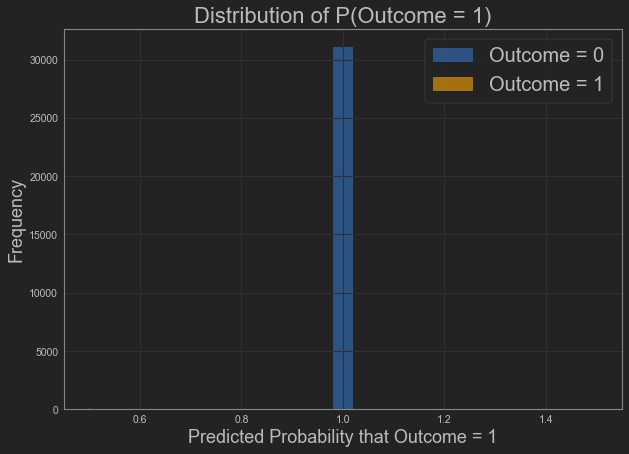

In [15]:
pred_proba = [i[1] for i in lr.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 65,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

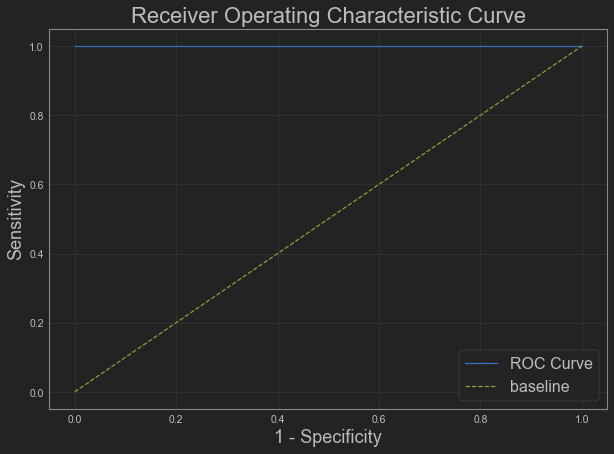

In [16]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [17]:
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.5

## Results

This approach also performed terribly (again likely due to class imbalance).  Some feature engineering or hyper parameter tuning could also help.